In [2]:
inputdir = "/group/jug/ashesh/facility_imganfacuser_ashesh/Ashesh/NatureMethodsSegmentation/2405_D18-M3-S0-L8_13/"
segmentationdir = "/group/jug/ashesh/facility_imganfacuser_ashesh/Ashesh/NatureMethodsSegmentationOutputs/Analysis_2405_D18-M3-S0-L8_13_1/"

OUTPUT_DIR = "/group/jug/ashesh/naturemethods/segmentation/three_analysts/"


In [3]:
from disentangle.core.tiff_reader import load_tiff
import os

ch_idx = 1  # which channel are we interested in doing segmentation.
gt = load_tiff(os.path.join(inputdir, "GT.tif"))
pred = load_tiff(os.path.join(inputdir, "pred_disentangle_2405_D18-M3-S0-L8_13_1.tif"))
pred.shape

/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')


(5, 2, 4096, 4096)

In [4]:
input = gt[:, 0] + gt[:, 1]
gt_ch = gt[:, ch_idx]
pred_ch = pred[:, ch_idx]
raw_dict = {"input": input, "pred": pred_ch, "GT": gt_ch}


In [5]:
from collections import defaultdict


def load_segmentation():
    # 2 level nested dictionary
    segmentation = defaultdict(lambda: defaultdict(list))
    for analystdir in os.listdir(segmentationdir):
        if analystdir == ".DS_Store":
            continue

        for subdir in ["GT", "input", "pred"]:
            dirpath = os.path.join(segmentationdir, analystdir, subdir)
            fnames = [f"seg_{i}.tif" for i in range(0, 5)]
            fpaths = [os.path.join(dirpath, fname) for fname in fnames]
            for fpath in fpaths:
                segmentation[analystdir][subdir].append(load_tiff(fpath))
    return segmentation

In [6]:
seg_data = load_segmentation()
analysts = list(seg_data.keys())

/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  data = imread(path, plugin='tifffile')
/localscratch/code/Disentangle/disentangle/core/tiff_reader.py:9: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will

In [7]:
analysts

['JB', 'DDN', 'EC']

In [8]:
import numpy as np


def dice_coefficient(x, y):
    assert set(np.unique(x)) == set([0, 1])
    assert set(np.unique(y)) == set([0, 1])
    intersection = np.sum(x[y == 1])
    union = np.sum(x) + np.sum(y)
    return 2 * intersection / union


In [9]:
len(seg_data["JB"]["GT"])

5

In [10]:
# import matplotlib.pyplot as plt
# from disentangle.analysis.plot_utils import clean_ax
# ex_idx =4
# ncols=4
# nrows = 3
# subres = 4

# imgsz = 3
# _, ax = plt.subplots(figsize=(ncols*imgsz, nrows*imgsz), ncols=ncols, nrows=nrows)

# for d_idx, datatype in enumerate(['input','pred','GT']):
#     ax[d_idx,0].imshow(raw_dict[datatype][ex_idx][::subres,::subres], cmap='magma')
#     for a_idx, analyst in enumerate(analysts):
#         ax[d_idx, 1+a_idx].imshow(seg_data[analyst][datatype][ex_idx][::subres,::subres], cmap='gray')
#         # ax[d_idx, 1+a_idx].set_title(f'{analyst} {datatype}')

# clean_ax(ax)
# # remove subspaces between subplots
# plt.subplots_adjust(wspace=0.02, hspace=0.02)


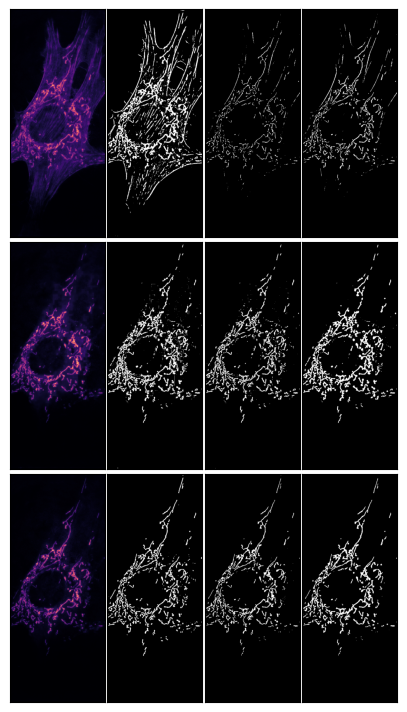

In [11]:
import matplotlib.pyplot as plt
from disentangle.analysis.plot_utils import clean_ax

ex_idx = 4
transpose = False
save_to_file = False


ncols = 4
nrows = 3
subres = 4
# how much do we want to reduce the width of the image
width_factor = 5 / 12
new_w = int(gt.shape[-2] * width_factor)
new_w += (gt.shape[-2] - new_w) % 2
extra_w = (gt.shape[-2] - new_w) // 2
imgsz = 3
_, ax = plt.subplots(figsize=(ncols * imgsz * width_factor, nrows * imgsz), ncols=ncols, nrows=nrows)

for d_idx, datatype in enumerate(["input", "pred", "GT"]):
    raw_img = raw_dict[datatype][ex_idx]
    if transpose:
        raw_img = raw_img.T
    ax[d_idx, 0].imshow(raw_img[:, extra_w:-extra_w][::subres, ::subres], cmap="magma")
    for a_idx, analyst in enumerate(analysts):
        seg_img = seg_data[analyst][datatype][ex_idx]
        if transpose:
            seg_img = seg_img.T
        ax[d_idx, 1 + a_idx].imshow(seg_img[:, extra_w:-extra_w][::subres, ::subres], cmap="gray", vmin=0, vmax=1)
        # ax[d_idx, 1+a_idx].set_title(f'{analyst} {datatype}')

clean_ax(ax)
# remove subspaces between subplots
plt.subplots_adjust(wspace=0.02, hspace=0.02)
if save_to_file:
    model_token = os.path.basename(inputdir.strip("/"))
    fname = f"segmentation_3analyst_Idx{ex_idx}_{model_token}.png"
    fpath = os.path.join(OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi=100, bbox_inches="tight")


In [12]:
import numpy as np


def dice_coefficient(x, y):
    assert set(np.unique(x)) == set([0, 1])
    assert set(np.unique(y)) == set([0, 1])
    intersection = np.sum(x[y == 1])
    union = np.sum(x) + np.sum(y)
    return 2 * intersection / union


def add_text(ax, text, img_shape, place="TOP_LEFT"):
    """
    Adding text on image
    """
    assert place in ["TOP_LEFT", "BOTTOM_RIGHT"]
    if place == "TOP_LEFT":
        ax.text(40, 110, text, bbox=dict(facecolor="white", alpha=0.9))
    elif place == "BOTTOM_RIGHT":
        s0 = img_shape[1]
        s1 = img_shape[0]
        ax.text(s0 - s0 * 150 / 500, s1 - s1 * 35 / 500, text, bbox=dict(facecolor="white", alpha=0.9))


In [13]:
for analyst in analysts:
    dice_gt_input = [
        dice_coefficient(seg_data[analyst]["GT"][idx], seg_data[analyst]["input"][idx])
        for idx in range(len(seg_data[analyst]["GT"]))
    ]
    dice_gt_pred = [
        dice_coefficient(seg_data[analyst]["GT"][idx], seg_data[analyst]["pred"][idx])
        for idx in range(len(seg_data[analyst]["GT"]))
    ]
    print("GT vs Input", analyst, dice_gt_input)
    print("GT vs Pred", analyst, dice_gt_pred)

seg_data["JB"]["GT"][0].shape, seg_data["JB"]["pred"][0].shape

GT vs Input JB [np.float64(0.475950519516178), np.float64(0.2728530099048941), np.float64(0.3337633133418592), np.float64(0.3941699159656219), np.float64(0.5655686266210749)]
GT vs Pred JB [np.float64(0.8102336059762033), np.float64(0.7376277422756354), np.float64(0.8274979214231982), np.float64(0.8017130392647291), np.float64(0.7831929542722971)]
GT vs Input DDN [np.float64(0.5588717180656727), np.float64(0.3846169410590354), np.float64(0.44074844828586346), np.float64(0.48462395543175485), np.float64(0.5756924865890716)]
GT vs Pred DDN [np.float64(0.8435241837220061), np.float64(0.7887258697195407), np.float64(0.8806935263790047), np.float64(0.7637059205840803), np.float64(0.7893838806499786)]
GT vs Input EC [np.float64(0.6554452404639021), np.float64(0.44922149834523323), np.float64(0.5300734143279007), np.float64(0.5957861717179239), np.float64(0.6735532320262936)]
GT vs Pred EC [np.float64(0.8840796342659833), np.float64(0.7809461195947763), np.float64(0.8748010269934238), np.floa

((4096, 4096), (4096, 4096))

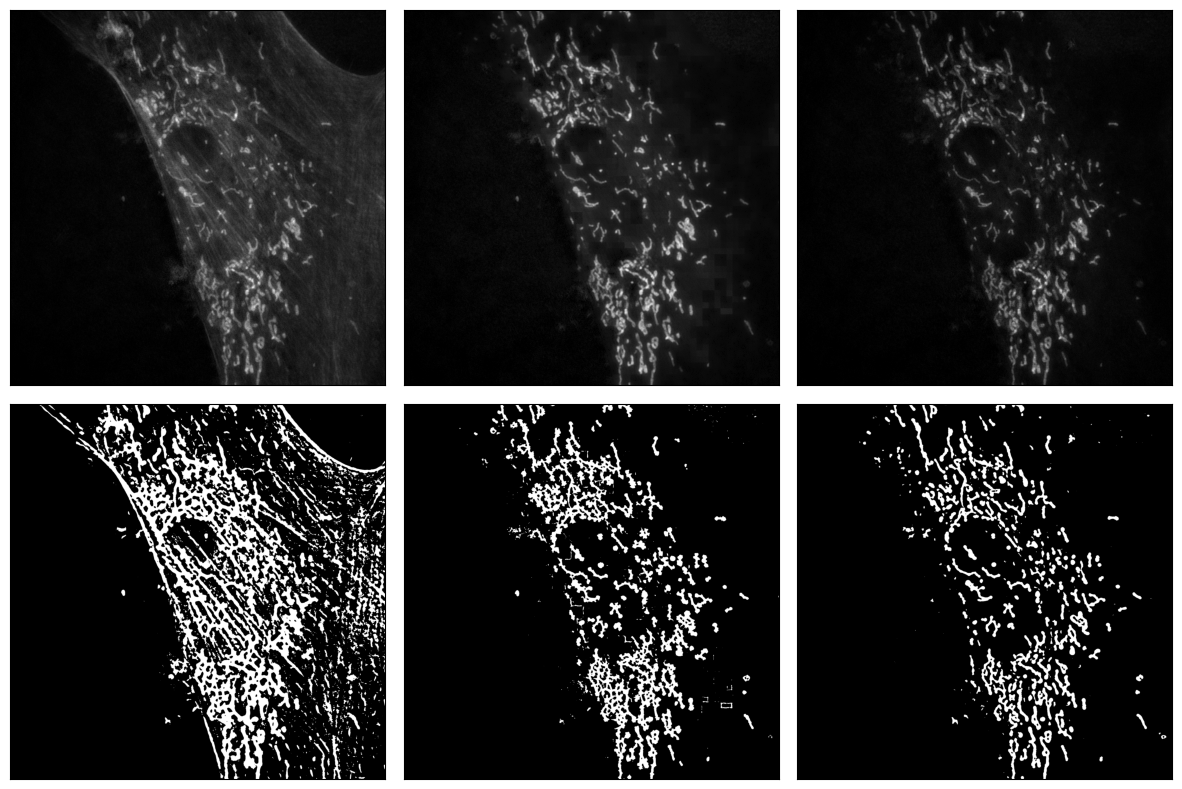

In [14]:
from disentangle.analysis.plot_utils import clean_ax
import matplotlib.pyplot as plt

OneAnalyst_OUTPUT_DIR = OUTPUT_DIR.replace("three_analysts", "one_analyst")
reviewer_key = analysts[0]
seg_input = seg_data[reviewer_key]["input"][0]
seg_pred = seg_data[reviewer_key]["pred"][0]
seg_GT = seg_data[reviewer_key]["GT"][0]
img_idx = 0
img_size = 5
hs = 1000
he = 3000

ws = 1000
we = 3000
save_to_file = False

_, ax = plt.subplots(figsize=(3 * img_size, 2 * img_size), ncols=3, nrows=2)
ax[0, 0].imshow(raw_dict["input"][img_idx][hs:he, ws:we], cmap="gray")
ax[0, 1].imshow(raw_dict["pred"][img_idx][hs:he, ws:we], cmap="gray")
ax[0, 2].imshow(raw_dict["GT"][img_idx][hs:he, ws:we], cmap="gray")
ax[1, 0].imshow(seg_input[hs:he, ws:we], cmap="gray")
ax[1, 1].imshow(seg_pred[hs:he, ws:we], cmap="gray")
ax[1, 2].imshow(seg_GT[hs:he, ws:we], cmap="gray")

dice_input = dice_coefficient(seg_GT.flatten() > 0, seg_input.flatten() > 0)
dice_pred = dice_coefficient(seg_GT.flatten() > 0, seg_pred.flatten() > 0)
# add_text(ax[1,0], f'DICE: {dice_input:.2f}', seg_input.shape, place='TOP_LEFT')
# add_text(ax[1,1], f'DICE: {dice_pred:.2f}', seg_input.shape, place='TOP_LEFT')


clean_ax(ax)
# remove the space between the subplots
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_to_file:
    model_token = os.path.basename(inputdir.strip("/"))
    fname = f"segmentation_1analyst_reviewer:{reviewer_key}_{model_token}_{hs}-{he}-{ws}-{we}.png"
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi=100, bbox_inches="tight")


### DICE computation & visualization

In [15]:
dice_score_dict = {}
for review in seg_data:
    reviewer_seg = seg_data[review]
    gt_seg = reviewer_seg["GT"]
    pred_seg = reviewer_seg["pred"]
    input_seg = reviewer_seg["input"]
    dice_scores_pred = [dice_coefficient(gt.flatten() > 0, pred.flatten() > 0) for gt, pred in zip(gt_seg, pred_seg)]
    dice_scores_input = [
        dice_coefficient(gt.flatten() > 0, input.flatten() > 0) for gt, input in zip(gt_seg, input_seg)
    ]

    dice_score_dict[review] = {"pred": dice_scores_pred, "input": dice_scores_input}

In [16]:
import pandas as pd

pred_df = pd.DataFrame.from_dict({r: dice_score_dict[r]["pred"] for r in seg_data.keys()})
inp_df = pd.DataFrame.from_dict({r: dice_score_dict[r]["input"] for r in seg_data.keys()})

In [17]:
avg_pred = pred_df.mean(axis=0)
avg_inp = inp_df.mean(axis=0)

stderr_pred = pred_df.std(axis=0) / np.sqrt(pred_df.shape[0])
stderr_inp = inp_df.std(axis=0) / np.sqrt(inp_df.shape[0])

In [18]:
# import matplotlib.pyplot as plt
# _,ax = plt.subplots(figsize=(8,4))
# labels = avg_pred.index
# x = np.arange(len(labels))/2
# width = 0.1

# rects1 = ax.bar(x - width/2, avg_pred, width, label='MicroSplit Prediction', yerr=stderr_pred, capsize=3, color='cyan', ecolor='black')
# rects2 = ax.bar(x + width/2, avg_inp, width, label='MicrosSplit Input', yerr=stderr_inp, capsize=3, color='grey', ecolor='black')

# ax.set_ylabel('Dice Similarity Coefficient')
# ax.set_title('Segmentation Performance by Independent Analysts')
# ax.set_xticks(x)
# ax.set_xticklabels(['Analyst 1', 'Analyst 2', 'Analyst 3'])
# ax.legend(loc='upper right')
# ax.set_ylim([0,1.1])


In [19]:
dice_GT_score_dict = {}
for i1, an1 in enumerate(analysts):
    for i2, an2 in enumerate(analysts[i1 + 1 :]):
        if an1 == an2:
            continue

        gt_seg1 = seg_data[an1]["GT"]
        gt_seg2 = seg_data[an2]["GT"]
        print(an1, an2)
        dice_GT_score_dict[f"A{i1}-A{i1 + i2 + 1}"] = [
            dice_coefficient(gt1.flatten() > 0, gt2.flatten() > 0) for gt1, gt2 in zip(gt_seg1, gt_seg2)
        ]
inter_reviewer_variability_df = pd.DataFrame.from_dict(dice_GT_score_dict)

JB DDN
JB EC
DDN EC


In [20]:
import seaborn as sns

In [21]:
pred_df.columns = [f"A{i}" for i in range(3)]
pred_df

,A0,A1,A2
0,0.810234,0.843524,0.884080
1,0.737628,0.788726,0.780946
2,0.827498,0.880694,0.874801
3,0.801713,0.763706,0.810638
4,0.783193,0.789384,0.818859


In [22]:
inter_reviewer_variability_df

,A0-A1,A0-A2,A1-A2
0,0.873969,0.859032,0.860289
1,0.857449,0.869406,0.870584
2,0.894316,0.860001,0.858953
3,0.836412,0.846904,0.872029
4,0.874373,0.879541,0.877203


/tmp/ipykernel_16755/3325977648.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color="0.95", palette=colors)


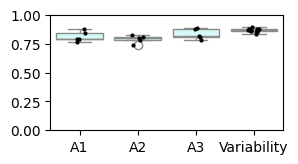

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

save_to_file = False

df = pred_df[["A1", "A0", "A2"]].copy()
df.columns = ["A1", "A2", "A3"]
variability_df = pd.Series(
    inter_reviewer_variability_df.values.reshape(
        -1,
    )
).to_frame("Variability")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(3, 1.5))

# Create the boxplot
colors = ["#D0FFFD", "#D0FFFD", "#D0FFFD", "0.95"]
bp = sns.boxplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color="0.95", palette=colors)

# Create the scatter plot (strip plot) on top of the boxplot
sns.stripplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color="black", jitter=True, size=3)

plt.ylim(0.0, 1.0)

# Show the plot
if save_to_file:
    model_token = os.path.basename(inputdir.strip("/"))
    fname = f"segmentation_3analyst_quantitative_{model_token}.png"
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi=100, bbox_inches="tight")

/tmp/ipykernel_16755/2399028844.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(data=boxplot_df, ax=ax, color="0.95", palette=colors, width=0.4)


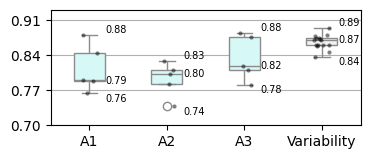

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

save_to_file = False

df = pred_df[["A1", "A0", "A2"]].copy()
df.columns = ["A1", "A2", "A3"]
variability_df = pd.Series(
    inter_reviewer_variability_df.values.reshape(
        -1,
    )
).to_frame("Variability")

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 1.5))
# fig, ax = plt.subplots(figsize=(4, 1.5))

# Create the boxplot
colors = ["#D0FFFD", "#D0FFFD", "#D0FFFD", "0.95"]
boxplot_df = pd.concat([df, variability_df], axis=1)
bp = sns.boxplot(data=boxplot_df, ax=ax, color="0.95", palette=colors, width=0.4)
# show values for min, max, mean for each box. it should be right side of each box
for i, col in enumerate(boxplot_df.columns):
    col_data = boxplot_df[col]
    min_val = col_data.min()
    max_val = col_data.max()
    median_val = col_data.median()
    if i == 3:
        ax.text(i + 0.35, min_val, f"{min_val:.2f}", ha="center", va="top", fontsize=7)
        ax.text(i + 0.35, max_val, f"{max_val:.2f}", ha="center", va="bottom", fontsize=7)
        ax.text(i + 0.35, median_val, f"{median_val:.2f}", ha="center", va="center", fontsize=7)
    else:
        ax.text(i + 0.35, min_val, f"{min_val:.2f}", ha="center", va="top", fontsize=7)
        ax.text(i + 0.35, max_val, f"{max_val:.2f}", ha="center", va="bottom", fontsize=7)
        ax.text(i + 0.35, median_val, f"{median_val:.2f}", ha="center", va="center", fontsize=7)

# Create the scatter plot (strip plot) on top of the boxplot
sns.stripplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color="black", jitter=True, size=3, alpha=0.5)

# enable fine grid lines in y axis
ax.yaxis.set_major_locator(plt.MultipleLocator(0.07))

ax.yaxis.grid(True)

plt.ylim(0.7, 0.93)

# Show the plot
if save_to_file:
    model_token = os.path.basename(inputdir.strip("/"))
    fname = f"segmentation_3analyst_quantitative_{model_token}.pdf"
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi=200, bbox_inches="tight")

/group/jug/ashesh/naturemethods/segmentation/one_analyst/segmentation_3analyst_quantitative_2405_D18-M3-S0-L8_13.pdf


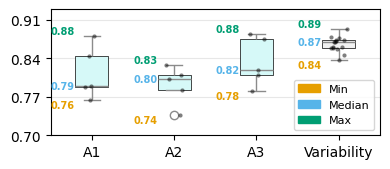

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

save_to_file = True
df = pred_df[["A1", "A0", "A2"]].copy()
df.columns = ["A1", "A2", "A3"]
variability_df = pd.Series(
    inter_reviewer_variability_df.values.reshape(
        -1,
    )
).to_frame("Variability")

# Colorblind-friendly colors (viridis-inspired)
MIN_COLOR = "#E69F00"  # (orange)
MEDIAN_COLOR = "#56B4E9"  # (sky blue)  # Teal
MAX_COLOR = "#009E73"  # (bluish green)  # Dark green

# Create a figure and axis
fig, ax = plt.subplots(figsize=(4, 1.8))

# Create the boxplot
colors = ["#D0FFFD", "#D0FFFD", "#D0FFFD", "0.95"]
boxplot_df = pd.concat([df, variability_df], axis=1)
bp = sns.boxplot(data=boxplot_df, ax=ax, palette=colors, width=0.4)

# Style boxplots
for patch in bp.patches:
    patch.set_linewidth(0.5)
    patch.set_edgecolor("black")

# Show values for min, max, median for each box (right side)
for i, col in enumerate(boxplot_df.columns):
    col_data = boxplot_df[col]
    min_val = col_data.min()
    max_val = col_data.max()
    median_val = col_data.median()

    x_pos = i - 0.35
    # Min (deep purple)
    ax.text(x_pos, min_val, f"{min_val:.2f}", ha="center", va="top", fontsize=7, color=MIN_COLOR, fontweight="bold")
    # Max (yellow)
    ax.text(x_pos, max_val, f"{max_val:.2f}", ha="center", va="bottom", fontsize=7, color=MAX_COLOR, fontweight="bold")
    # Median (teal)
    ax.text(
        x_pos,
        median_val,
        f"{median_val:.2f}",
        ha="center",
        va="center",
        fontsize=7,
        color=MEDIAN_COLOR,
        fontweight="bold",
    )

# Create the scatter plot
sns.stripplot(data=pd.concat([df, variability_df], axis=1), ax=ax, color="black", jitter=True, size=3, alpha=0.5)

# Colorblind-friendly legend
legend_elements = [
    mpatches.Patch(color=MIN_COLOR, label="Min"),
    mpatches.Patch(color=MEDIAN_COLOR, label="Median"),
    mpatches.Patch(color=MAX_COLOR, label="Max"),
]

# Legend outside plot
ax.legend(handles=legend_elements, loc="lower right", fontsize=8, frameon=True)

# Formatting
ax.yaxis.set_major_locator(plt.MultipleLocator(0.07))
ax.yaxis.grid(True, alpha=0.3)
plt.ylim(0.7, 0.93)
plt.tight_layout()

if save_to_file:
    model_token = os.path.basename(inputdir.strip("/"))
    fname = f"segmentation_3analyst_quantitative_{model_token}.pdf"
    fpath = os.path.join(OneAnalyst_OUTPUT_DIR, fname)
    print(fpath)
    plt.savefig(fpath, dpi=200, bbox_inches="tight", pad_inches=0.1)

plt.show()
